# Dependencies

In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sys
import os

# Add src to path
sys.path.append(os.path.join(os.getcwd(), 'src'))

from src.models import Slots
from src.agents.agent_class import RandomAgent
from src.agents.cap_based_agent import CapAgent
from src.agents.dynamic_cap_based_agent import DynamicCapAgent
from src.agents.rl_deep_agent import RLDeepAgent
from src.auction import Auction
from src.data_loader import load_players_from_excel

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

## Define Auction Configurations

In [2]:
def refresh_agents():
    agents = [
            CapAgent(agent_id="cap_bestx1_balanced", cap_strategy="bestxi_based"),
            CapAgent(agent_id="cap_bestx1_aggressive", cap_strategy="bestxi_based", bestxi_budget=0.99),
            CapAgent(agent_id="cap_tier", cap_strategy="tier_based"),
            DynamicCapAgent(agent_id="dynamic_cap_bestx1_balanced", cap_strategy="bestxi_based", bestxi_budget=0.95),
            DynamicCapAgent(agent_id="dynamic_cap_bestx1_aggressive", cap_strategy="bestxi_based", bestxi_budget=0.99),
            DynamicCapAgent(agent_id="dynamic_cap_tier", cap_strategy="tier_based"),
            RLDeepAgent(agent_id="RLDeepAgent", mode = "training"),
            RandomAgent(agent_id="random_1")
        ]
    return agents

# Auction configurations to test
auction_types = [
    {"auction_type": "random", "per_ruolo": True},
    {"auction_type": "random", "per_ruolo": False},
    {"auction_type": "listone", "per_ruolo": True},
    {"auction_type": "listone", "per_ruolo": False},
    {"auction_type": "chiamata", "per_ruolo": True},
    {"auction_type": "chiamata", "per_ruolo": False}
]

initial_credits = 1000
slots = Slots()
print(f"Slots: {slots}")

Slots: <src.models.Slots object at 0x000001F9BC795160>


## Simulation Functions

In [3]:
def run_single_simulation(auction_types, slots, initial_credits, sim_id):
    """Run a single auction simulation with the 8 fixed agents"""
    
    # reload the listone and agents every simulation
    listone = load_players_from_excel()
    agents = refresh_agents()  
    random.shuffle(agents)  # Shuffle order for each simulation
    
    # Create and run auction
    auction = Auction(slots, agents, listone, initial_credits)
    auction.run_all(
        auction_type=auction_types["auction_type"],
        per_ruolo=auction_types["per_ruolo"],
        verbose=False
    )
    
    # Collect results - focus on key metrics
    results = []
    for agent in auction.agents:
        # Calculate credits spent and player count
        credits_spent = initial_credits - agent.current_credits
        players_count = len(agent.squad.gk) + len(agent.squad.def_) + len(agent.squad.mid) + len(agent.squad.att)
        
        squad_metrics = {
            "simulation_id": sim_id,
            "auction_type": auction_types["auction_type"],
            "per_ruolo": auction_types["per_ruolo"],
            "agent_id": agent.agent_id,
            "agent_type": type(agent).__name__,
            "total_evaluation": agent.squad.objective(standardized=True),
            "bestxi_evaluation": agent.squad.objective(bestxi=True, standardized=True),
            "credits_spent": credits_spent,
            "players_count": players_count,
        }
        
        # Add agent-specific parameters
        if hasattr(agent, 'bestxi_budget'):
            squad_metrics["bestxi_budget"] = agent.bestxi_budget
        
        results.append(squad_metrics)
    
    return results

print("✅ Simulation functions defined")

✅ Simulation functions defined


## Run Multiple Simulations

In [4]:
# Configuration for the simulation run
num_simulations_per_config = 1  # 1 simulation per auction configuration
total_simulations = len(auction_types) * num_simulations_per_config

print(f"🚀 Running {len(auction_types)} auction configs × {num_simulations_per_config} simulations = {total_simulations} total simulations...")

# Run all simulations
all_results = []
current_sim = 0

for auction_config in auction_types:
    for sim_num in range(num_simulations_per_config):
        current_sim += 1
        sim_id = f"{auction_config['auction_type']}_{auction_config['per_ruolo']}_{sim_num+1}"
        
        print(f"📊 Running simulation {current_sim}/{total_simulations}: {sim_id}")
        
        # Set random seed for reproducible shuffling within each sim
        random.seed(current_sim * 42)
        
        results = run_single_simulation(
            auction_config, 
            slots, 
            initial_credits, 
            sim_id
        )
        
        all_results.extend(results)

print(f"\n✅ Completed {total_simulations} simulations!")
print(f"📈 Collected {len(all_results)} agent results")

🚀 Running 6 auction configs × 1 simulations = 6 total simulations...
📊 Running simulation 1/6: random_True_1
📊 Running simulation 2/6: random_False_1
📊 Running simulation 3/6: listone_True_1
📊 Running simulation 4/6: listone_False_1
📊 Running simulation 5/6: chiamata_True_1
📊 Running simulation 6/6: chiamata_False_1

✅ Completed 6 simulations!
📈 Collected 48 agent results


## Analyze Results

In [5]:
# Convert results to DataFrame for analysis
df_results = pd.DataFrame(all_results)

print("📊 Results Summary:")
print(f"Total simulations: {df_results['simulation_id'].nunique()}")
print(f"Total agent results: {len(df_results)}")
print(f"Results per agent: {len(df_results) // 8}")

print(f"\n📋 Agent distribution:")
print(df_results['agent_id'].value_counts().sort_index())

📊 Results Summary:
Total simulations: 6
Total agent results: 48
Results per agent: 6

📋 Agent distribution:
agent_id
RLDeepAgent                      6
cap_bestx1_aggressive            6
cap_bestx1_balanced              6
cap_tier                         6
dynamic_cap_bestx1_aggressive    6
dynamic_cap_bestx1_balanced      6
dynamic_cap_tier                 6
random_1                         6
Name: count, dtype: int64


## Performance Analysis by Agent Type

In [6]:
# Agent Performance Summary Table
print("🏆 AGENT PERFORMANCE SUMMARY")
print("="*80)

agent_summary = df_results.groupby('agent_id').agg({
    'total_evaluation': ['mean', 'std', 'min', 'max'],
    'bestxi_evaluation': ['mean', 'std', 'min', 'max']
}).round(1)

# Flatten column names
agent_summary.columns = ['_'.join(col).strip() for col in agent_summary.columns.values]
agent_summary = agent_summary.reset_index()

# Sort by bestxi_evaluation mean (descending)
agent_summary = agent_summary.sort_values('bestxi_evaluation_mean', ascending=False)

print("\nRanked by Best XI Performance:")
for _, row in agent_summary.iterrows():
    print(f"{row['agent_id']:20} | Best XI: {row['bestxi_evaluation_mean']:5.1f} ± {row['bestxi_evaluation_std']:4.1f} | Total: {row['total_evaluation_mean']:5.1f} ± {row['total_evaluation_std']:4.1f}")

print(f"\nDetailed table:")
display(agent_summary)

🏆 AGENT PERFORMANCE SUMMARY

Ranked by Best XI Performance:
cap_tier             | Best XI:   3.3 ±  0.8 | Total:   4.5 ±  0.7
cap_bestx1_aggressive | Best XI:   2.9 ±  0.4 | Total:   4.4 ±  0.8
cap_bestx1_balanced  | Best XI:   2.7 ±  0.4 | Total:   4.3 ±  0.5
RLDeepAgent          | Best XI:   2.1 ±  0.7 | Total:   2.8 ±  0.9
dynamic_cap_bestx1_aggressive | Best XI:   2.1 ±  0.3 | Total:   3.2 ±  0.8
dynamic_cap_tier     | Best XI:   1.9 ±  0.7 | Total:   2.7 ±  1.1
dynamic_cap_bestx1_balanced | Best XI:   1.6 ±  0.7 | Total:   2.6 ±  1.2
random_1             | Best XI:   1.5 ±  0.7 | Total:   2.1 ±  1.2

Detailed table:


,agent_id,total_evaluation_mean,total_evaluation_std,total_evaluation_min,total_evaluation_max,bestxi_evaluation_mean,bestxi_evaluation_std,bestxi_evaluation_min,bestxi_evaluation_max
3,cap_tier,4.5,0.7,3.8,5.3,3.3,0.8,2.4,4.3
1,cap_bestx1_aggressive,4.4,0.8,3.0,5.1,2.9,0.4,2.3,3.3
2,cap_bestx1_balanced,4.3,0.5,3.8,4.9,2.7,0.4,2.1,3.4
0,RLDeepAgent,2.8,0.9,1.4,4.1,2.1,0.7,1.1,3.2
4,dynamic_cap_bestx1_aggressive,3.2,0.8,2.3,4.1,2.1,0.3,1.7,2.5
6,dynamic_cap_tier,2.7,1.1,1.6,4.1,1.9,0.7,1.1,2.8
5,dynamic_cap_bestx1_balanced,2.6,1.2,1.5,4.1,1.6,0.7,0.8,2.5
7,random_1,2.1,1.2,0.9,3.9,1.5,0.7,0.7,2.8


## Credits Spent and Player Count Analysis

Compare the distribution of credits spent and number of players acquired by each agent across all simulations.

C:\Users\huawei\AppData\Local\Temp\ipykernel_1780\3415846339.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x='agent_id', y='credits_spent',
C:\Users\huawei\AppData\Local\Temp\ipykernel_1780\3415846339.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x='agent_id', y='players_count',


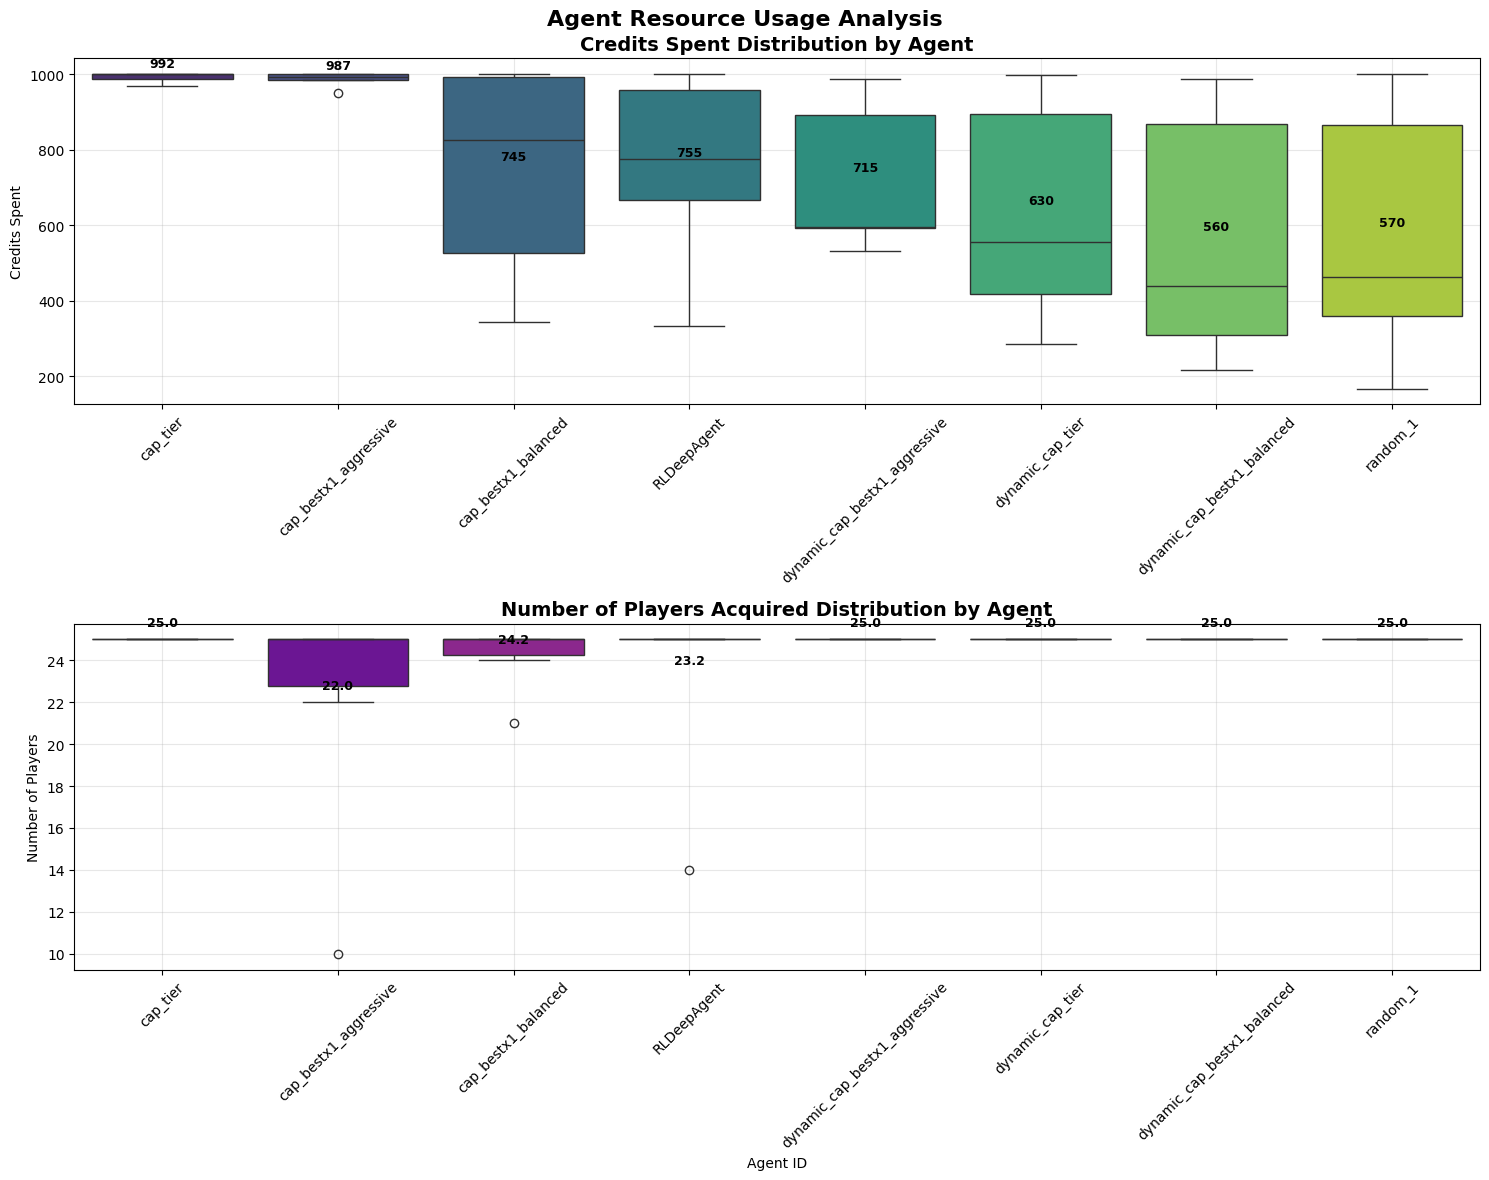

💰 CREDITS SPENT ANALYSIS
cap_tier             | Mean:  991.8 | Std:  13.0 | Range:  969-1000
cap_bestx1_aggressive | Mean:  986.7 | Std:  19.4 | Range:  950-1000
cap_bestx1_balanced  | Mean:  745.3 | Std: 289.9 | Range:  344-1000
RLDeepAgent          | Mean:  755.0 | Std: 252.3 | Range:  333-1000
dynamic_cap_bestx1_aggressive | Mean:  715.3 | Std: 212.7 | Range:  531- 988
dynamic_cap_tier     | Mean:  629.5 | Std: 303.9 | Range:  286- 998
dynamic_cap_bestx1_balanced | Mean:  560.3 | Std: 343.8 | Range:  217- 986
random_1             | Mean:  570.2 | Std: 350.4 | Range:  168-1000

👥 PLAYER COUNT ANALYSIS
cap_tier             | Mean:   25.0 | Std:   0.0 | Range:   25-  25
cap_bestx1_aggressive | Mean:   22.0 | Std:   6.0 | Range:   10-  25
cap_bestx1_balanced  | Mean:   24.2 | Std:   1.6 | Range:   21-  25
RLDeepAgent          | Mean:   23.2 | Std:   4.5 | Range:   14-  25
dynamic_cap_bestx1_aggressive | Mean:   25.0 | Std:   0.0 | Range:   25-  25
dynamic_cap_tier     | Mean:   25.0 | S

In [7]:
# Create visualizations for credits spent and player counts
agents_list = df_results['agent_id'].unique()
agents_list = sorted(agents_list)  # Sort for consistent ordering

# Create a 2x1 subplot for credits and player counts
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
fig.suptitle('Agent Resource Usage Analysis', fontsize=16, fontweight='bold')

# Sort agents by performance for better visualization
agent_order = df_results.groupby('agent_id')['bestxi_evaluation'].mean().sort_values(ascending=False).index

# Credits Spent Distribution
sns.boxplot(data=df_results, x='agent_id', y='credits_spent', 
           order=agent_order, ax=ax1, palette="viridis")
ax1.set_title('Credits Spent Distribution by Agent', fontsize=14, fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('Credits Spent')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Add mean values as text
for i, agent in enumerate(agent_order):
    mean_credits = df_results[df_results['agent_id'] == agent]['credits_spent'].mean()
    ax1.text(i, mean_credits + 20, f'{mean_credits:.0f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=9)

# Player Count Distribution
sns.boxplot(data=df_results, x='agent_id', y='players_count', 
           order=agent_order, ax=ax2, palette="plasma")
ax2.set_title('Number of Players Acquired Distribution by Agent', fontsize=14, fontweight='bold')
ax2.set_xlabel('Agent ID')
ax2.set_ylabel('Number of Players')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Add mean values as text
for i, agent in enumerate(agent_order):
    mean_players = df_results[df_results['agent_id'] == agent]['players_count'].mean()
    ax2.text(i, mean_players + 0.5, f'{mean_players:.1f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary statistics
print("💰 CREDITS SPENT ANALYSIS")
print("="*60)
credits_summary = df_results.groupby('agent_id')['credits_spent'].agg(['mean', 'std', 'min', 'max']).round(1)
credits_summary = credits_summary.loc[agent_order]
for agent in agent_order:
    stats = credits_summary.loc[agent]
    print(f"{agent:20} | Mean: {stats['mean']:6.1f} | Std: {stats['std']:5.1f} | Range: {stats['min']:4.0f}-{stats['max']:4.0f}")

print(f"\n👥 PLAYER COUNT ANALYSIS")
print("="*60)
players_summary = df_results.groupby('agent_id')['players_count'].agg(['mean', 'std', 'min', 'max']).round(1)
players_summary = players_summary.loc[agent_order]
for agent in agent_order:
    stats = players_summary.loc[agent]
    print(f"{agent:20} | Mean: {stats['mean']:6.1f} | Std: {stats['std']:5.1f} | Range: {stats['min']:4.0f}-{stats['max']:4.0f}")

print(f"\n💡 Resource usage patterns show how different strategies allocate credits and acquire players")

## Comparative Box Plots

Side-by-side comparison of all agents showing quartiles and outliers.

C:\Users\huawei\AppData\Local\Temp\ipykernel_1780\3828490767.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x='agent_id', y='bestxi_evaluation',
C:\Users\huawei\AppData\Local\Temp\ipykernel_1780\3828490767.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x='agent_id', y='total_evaluation',


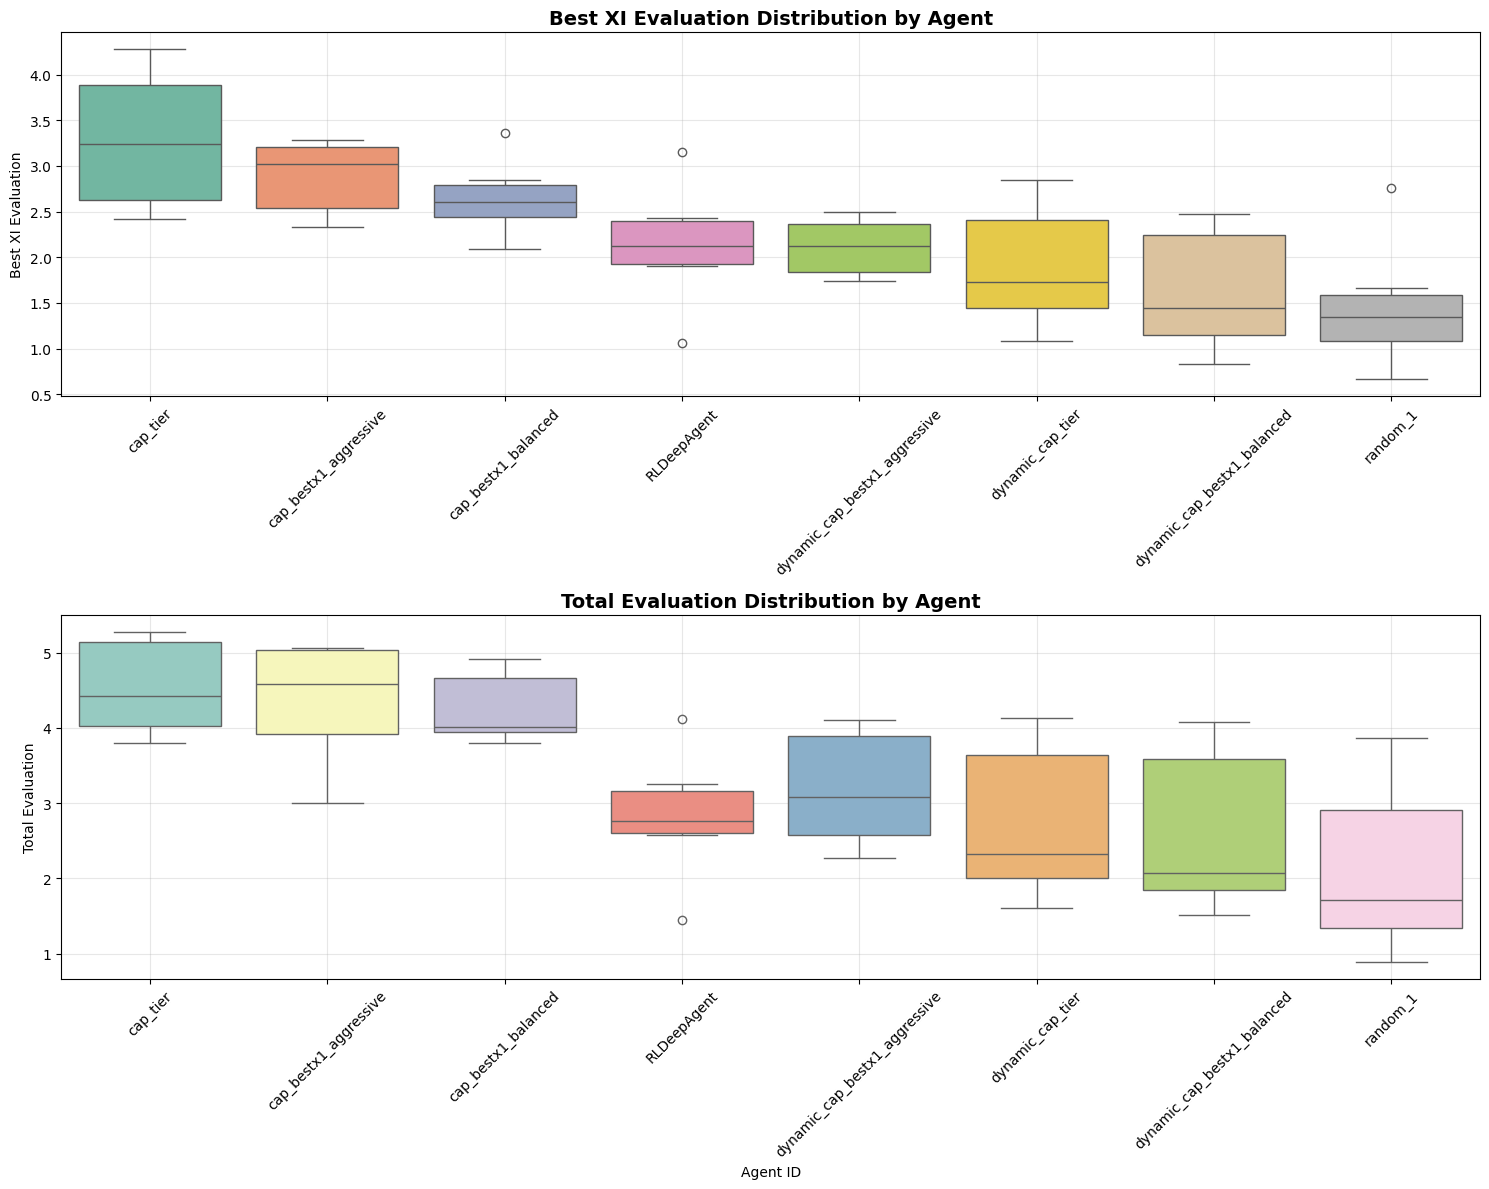

🏆 AGENT RANKINGS

By Best XI Evaluation (mean):
 1. cap_tier             3.3
 2. cap_bestx1_aggressive 2.9
 3. cap_bestx1_balanced  2.7
 4. RLDeepAgent          2.1
 5. dynamic_cap_bestx1_aggressive 2.1
 6. dynamic_cap_tier     1.9
 7. dynamic_cap_bestx1_balanced 1.6
 8. random_1             1.5

By Total Evaluation (mean):
 1. cap_tier             4.5
 2. cap_bestx1_aggressive 4.4
 3. cap_bestx1_balanced  4.3
 4. dynamic_cap_bestx1_aggressive 3.2
 5. RLDeepAgent          2.8
 6. dynamic_cap_tier     2.7
 7. dynamic_cap_bestx1_balanced 2.6
 8. random_1             2.1


In [8]:
# Create comparative box plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Sort agents by performance for better visualization
agent_order = df_results.groupby('agent_id')['bestxi_evaluation'].mean().sort_values(ascending=False).index

# Best XI Evaluation box plot
sns.boxplot(data=df_results, x='agent_id', y='bestxi_evaluation', 
           order=agent_order, ax=ax1, palette="Set2")
ax1.set_title('Best XI Evaluation Distribution by Agent', fontsize=14, fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('Best XI Evaluation')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Total Evaluation box plot
sns.boxplot(data=df_results, x='agent_id', y='total_evaluation', 
           order=agent_order, ax=ax2, palette="Set3")
ax2.set_title('Total Evaluation Distribution by Agent', fontsize=14, fontweight='bold')
ax2.set_xlabel('Agent ID')
ax2.set_ylabel('Total Evaluation')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print ranking
print("🏆 AGENT RANKINGS")
print("="*50)
print("\nBy Best XI Evaluation (mean):")
for i, agent in enumerate(agent_order, 1):
    mean_score = df_results[df_results['agent_id'] == agent]['bestxi_evaluation'].mean()
    print(f"{i:2}. {agent:20} {mean_score:.1f}")

print(f"\nBy Total Evaluation (mean):")
total_order = df_results.groupby('agent_id')['total_evaluation'].mean().sort_values(ascending=False).index
for i, agent in enumerate(total_order, 1):
    mean_score = df_results[df_results['agent_id'] == agent]['total_evaluation'].mean()
    print(f"{i:2}. {agent:20} {mean_score:.1f}")

## Export Results and Summary

In [9]:
# Save results to CSV for further analysis
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_filename = f"logs/agent_performance_{timestamp}.csv"

df_results.to_csv(results_filename, index=False)
print(f"📁 Results saved to: {results_filename}")

# Final summary
print(f"\n📊 FINAL SUMMARY")
print("="*60)
print(f"Total simulations run: {total_simulations}")
print(f"Results per agent: {total_simulations}")
print(f"Auction configurations tested: {len(auction_configs)}")

# Winner analysis
print(f"\n🏆 OVERALL WINNERS")
print("="*40)
best_bestxi = df_results.loc[df_results['bestxi_evaluation'].idxmax()]
best_total = df_results.loc[df_results['total_evaluation'].idxmax()]

print(f"Best XI champion: {best_bestxi['agent_id']} with {best_bestxi['bestxi_evaluation']:.1f}")
print(f"Total eval champion: {best_total['agent_id']} with {best_total['total_evaluation']:.1f}")

print(f"\nMost consistent performer (lowest std dev in Best XI):")
consistency = df_results.groupby('agent_id')['bestxi_evaluation'].std().sort_values()
most_consistent = consistency.index[0]
print(f"{most_consistent} (std dev: {consistency.iloc[0]:.1f})")

📁 Results saved to: logs/agent_performance_20250825_120646.csv

📊 FINAL SUMMARY
Total simulations run: 6
Results per agent: 6


NameError: name 'auction_configs' is not defined

## Key Insights

Based on the simulation results above:

### 🎯 **Agent Performance Insights:**
- **Kernel histograms** show the distribution shape for each agent's performance
- **Box plots** reveal quartiles, medians, and outliers for direct comparison
- **Rankings** identify the most effective strategies

### 📈 **What to Look For:**
1. **Consistent performers** - Agents with narrow distributions (low variance)
2. **High performers** - Agents with high mean scores
3. **Reliable strategies** - Agents that avoid very low scores
4. **CapAgent optimization** - Which bestxi_budget values work best

### 🔄 **Next Steps:**
- Increase `num_simulations_per_config` for more robust statistics
- Test different bestxi_budget values based on insights
- Focus on the top-performing agent strategies for real auctions